# 支持向量机（SVM）

* 优点：泛化错误率低、计算开销不大、结果易解释
* 缺点：对参数调节和核函数的选择敏感、原始分类器不加修饰仅适用与处理二类问题
* 适用数据类型：数值型和标称型数据

In [6]:
import numpy as np
from time import sleep

[-2, 12, -8, 6]

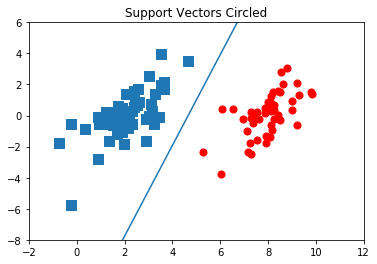

In [64]:
import numpy as np
import matplotlib.pyplot as plt

xcord0 = []
ycord0 = []
xcord1 = []
ycord1 = []
markers =[]
colors =[]
with open('testSet.txt') as fr:
    frLines = fr.readlines()#this file was generated by 2normalGen.py

for line in frLines:
    lineSplit = line.strip().split('\t')
    xPt = float(lineSplit[0])
    yPt = float(lineSplit[1])
    label = int(lineSplit[2])
    if (label == -1):
        xcord0.append(xPt)
        ycord0.append(yPt)
    else:
        xcord1.append(xPt)
        ycord1.append(yPt)
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xcord0,ycord0, marker='s', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('Support Vectors Circled')
b = -3.75567; w0=0.8065; w1=-0.2761
x = np.arange(-2.0, 12.0, 0.1)
y = (-w0*x - b)/w1
ax.plot(x,y)
ax.axis([-2,12,-8,6])

## SMO简化方法

In [8]:
#读取数据
def loadDataSet(fileName):
    dataMat = []
    labelMat = []
    with open(fileName) as fr:
        filelines = fr.readlines()
    for line in filelines:
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat, labelMat

In [9]:
fileName = 'testSet.txt'
dataMat, labelMat = loadDataSet(fileName)
dataMat, labelMat

([[3.542485, 1.977398],
  [3.018896, 2.556416],
  [7.55151, -1.58003],
  [2.114999, -0.004466],
  [8.127113, 1.274372],
  [7.108772, -0.986906],
  [8.610639, 2.046708],
  [2.326297, 0.265213],
  [3.634009, 1.730537],
  [0.341367, -0.894998],
  [3.125951, 0.293251],
  [2.123252, -0.783563],
  [0.887835, -2.797792],
  [7.139979, -2.329896],
  [1.696414, -1.212496],
  [8.117032, 0.623493],
  [8.497162, -0.266649],
  [4.658191, 3.507396],
  [8.197181, 1.545132],
  [1.208047, 0.2131],
  [1.928486, -0.32187],
  [2.175808, -0.014527],
  [7.886608, 0.461755],
  [3.223038, -0.552392],
  [3.628502, 2.190585],
  [7.40786, -0.121961],
  [7.286357, 0.251077],
  [2.301095, -0.533988],
  [-0.232542, -0.54769],
  [3.457096, -0.082216],
  [3.023938, -0.057392],
  [8.015003, 0.885325],
  [8.991748, 0.923154],
  [7.916831, -1.781735],
  [7.616862, -0.217958],
  [2.450939, 0.744967],
  [7.270337, -2.507834],
  [1.749721, -0.961902],
  [1.803111, -0.176349],
  [8.804461, 3.044301],
  [1.231257, -0.568573],

In [10]:
#i是alpha的下标，m是alpha的数目，只要函数值不等于输入值i，函数就会进行随机选择
def selectJrand(i,m):
    j=i #随机一个j不等于i
    while (j==i):
        j = int(np.random.uniform(0,m))
    return j

In [11]:
#辅助函数，用于调整大于H或者小于L的alpha的值
def clipAlpha(aj,H,L):
    if aj > H: 
        aj = H
    if L > aj:
        aj = L
    return aj

In [12]:
dataMatIn, classLabels, C, toler, maxIter = dataMat, labelMat, 0.6, 0.001, 40
dataMatIn, classLabels

([[3.542485, 1.977398],
  [3.018896, 2.556416],
  [7.55151, -1.58003],
  [2.114999, -0.004466],
  [8.127113, 1.274372],
  [7.108772, -0.986906],
  [8.610639, 2.046708],
  [2.326297, 0.265213],
  [3.634009, 1.730537],
  [0.341367, -0.894998],
  [3.125951, 0.293251],
  [2.123252, -0.783563],
  [0.887835, -2.797792],
  [7.139979, -2.329896],
  [1.696414, -1.212496],
  [8.117032, 0.623493],
  [8.497162, -0.266649],
  [4.658191, 3.507396],
  [8.197181, 1.545132],
  [1.208047, 0.2131],
  [1.928486, -0.32187],
  [2.175808, -0.014527],
  [7.886608, 0.461755],
  [3.223038, -0.552392],
  [3.628502, 2.190585],
  [7.40786, -0.121961],
  [7.286357, 0.251077],
  [2.301095, -0.533988],
  [-0.232542, -0.54769],
  [3.457096, -0.082216],
  [3.023938, -0.057392],
  [8.015003, 0.885325],
  [8.991748, 0.923154],
  [7.916831, -1.781735],
  [7.616862, -0.217958],
  [2.450939, 0.744967],
  [7.270337, -2.507834],
  [1.749721, -0.961902],
  [1.803111, -0.176349],
  [8.804461, 3.044301],
  [1.231257, -0.568573],

In [13]:
#简化的SMO算法
#@dataMat    ：数据列表
#@classLabels：标签列表
#@C          ：权衡因子（增加松弛因子而在目标优化函数中引入了惩罚项）
#@toler      ：容错率
#@maxIter    ：最大迭代次数
def smoSimple(dataMat,classLabels,C,toler,maxIter):
    dataMatrix = np.mat(dataMatIn)
    labelMat = np.mat(classLabels).transpose() #将矩阵的各个axis进行reverse
    b = 0
    m,n = np.shape(dataMatrix)
    alphas = np.mat(np.zeros((m,1))) #根据样本数量设定alpha的初始化
    iter = 0

    while (iter < maxIter): #但迭代次数小于最大迭代次数时，设定为40
        alphaPairsChanged = 0 #用于记录alpha是否已经进行优化

        for i in range(m): #对数据集中每个数据向量（内循环）
            #循环次数为样本数量，对整个集合进行循环遍历
            #简化版本的SMO未考虑变量的选择，只随机进行变量的更新，
            fXi = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b#计算分类决策函数所预测的输出值
            #multiply为对应位置相乘,，得到相应（100，1）矩阵，转置后（1，100） 
            #矩阵data（100，2）与对应当前i的内积（2，1）得到（100，1）内积结果
            #两个矩阵相乘加上偏置作为预测值
            Ei = fXi - float(labelMat[i])#计算误差Ei

            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):#如果该数据向量可以被优化

                # toler：容忍错误的程度
                # labelMat[i]*Ei < -toler 则需要alphas[i]增大，但是不能>=C
                # labelMat[i]*Ei > toler 则需要alphas[i]减小，但是不能<=0
                #如果不满足KKT条件，即labelMat[i]*fXi<1(labelMat[i]*fXi-1<-toler)and alpha<C 或者labelMat[i]*fXi>1(labelMat[i]*fXi-1>toler)and alpha>0
                #如果误差大于tolor容错率
                #关于alphas[i] < C和>C理解不了 （理解的很勉强）

                j = selectJrand(i,m) #随机选取第二个点进行更新

                fXj = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                #计算j点的预测
                Ej = fXj - float(labelMat[j])
                #误差计算
                alphaIold = alphas[i].copy()
                alphaJold = alphas[j].copy()#i和j的值旧值

                #保证alpha在0和C之间进行更新，根据yi与jj的值进行判定
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                #如上下界相同

                #上下界不符合条件，跳出
                if L==H: 
                    print("L==H")
                    continue#跳出循环

                #计算未经剪辑的alpha_j
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T

                #向量xi-向量xj的L2范数的相反数，所以要<=0，否则跳出
                #计算alpha更新中的其中一个参数-eta = K11+K22-2*K12
                if eta >= 0: 
                    print("eta>=0"); 
                    continue

                #P129页alpha更新
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                alphas[j] = clipAlpha(alphas[j],H,L) #根据范围进行上下限限定

                #若更新值变化不大，跳出本次循环
                if(abs(alphas[j]-alphaJold)<0.00001):
                    print("alpha j的改变值太小，跳出循环");
                    continue

                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])#由alpha j 的更新计算alpha i更新后的值

                #变量选择完成后P129、120推导 ，计算更新的b
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T

                if (0 < alphas[i]) and (C > alphas[i]): 
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): 
                    b = b2
                else: 
                    b = (b1 + b2)/2.0

                alphaPairsChanged += 1 #更新次数+1
                print("第几次迭代迭代: %d 第:%d个样本（i）, alpha改变的次数 %d" % (iter,i,alphaPairsChanged))

        #如果在一个迭代中，发生了alpha的更新，继续进行本次迭代，但没有改变的alpha时，在进行下一次的迭代
        if (alphaPairsChanged == 0): 
            iter += 1
        else: #置0继续当前迭代循环
            iter = 0
        print("当前迭代: %d" % iter) 
    return b,alphas

In [14]:
dataMatIn, classLabels, C, toler, maxIter = dataMat, labelMat, 0.6, 0.001, 40
b , alpha = smoSimple(dataMat,classLabels,C,toler,maxIter)

L==H
L==H
第几次迭代迭代: 0 第:2个样本（i）, alpha改变的次数 1
第几次迭代迭代: 0 第:3个样本（i）, alpha改变的次数 2
第几次迭代迭代: 0 第:4个样本（i）, alpha改变的次数 3
L==H
L==H
L==H
L==H
第几次迭代迭代: 0 第:11个样本（i）, alpha改变的次数 4
L==H
alpha j的改变值太小，跳出循环
L==H
L==H
L==H
第几次迭代迭代: 0 第:29个样本（i）, alpha改变的次数 5
alpha j的改变值太小，跳出循环
第几次迭代迭代: 0 第:45个样本（i）, alpha改变的次数 6
第几次迭代迭代: 0 第:46个样本（i）, alpha改变的次数 7
alpha j的改变值太小，跳出循环
L==H
L==H
L==H
第几次迭代迭代: 0 第:57个样本（i）, alpha改变的次数 8
alpha j的改变值太小，跳出循环
L==H
当前迭代: 0
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
第几次迭代迭代: 0 第:3个样本（i）, alpha改变的次数 1
alpha j的改变值太小，跳出循环
L==H
L==H
alpha j的改变值太小，跳出循环
L==H
第几次迭代迭代: 0 第:19个样本（i）, alpha改变的次数 2
alpha j的改变值太小，跳出循环
第几次迭代迭代: 0 第:23个样本（i）, alpha改变的次数 3
第几次迭代迭代: 0 第:24个样本（i）, alpha改变的次数 4
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
L==H
alpha j的改变值太小，跳出循环
第几次迭代迭代: 0 第:46个样本（i）, alpha改变的次数 5
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
L==H
L==H
第几次迭代迭代: 0 第:57个样本（i）, alpha改变的次数 6
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太

alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 1
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
第几次迭代迭代: 1 第:54个样本（i）, alpha改变的次数 1
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 0
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 1
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
第几次迭代迭代: 1 第:52个样本（i）, alpha改变的次数 1
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 0
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 1
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 2
alpha 

当前迭代: 0
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 1
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 2
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 3
第几次迭代迭代: 3 第:17个样本（i）, alpha改变的次数 1
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 0
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 1
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 2
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
第几次迭代迭代: 2 第:55个样本（i）, alpha改变的次数 1
当前迭代: 0
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 1
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 2
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 3
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
第几次迭代迭代: 3 第:54个样本（i）, alpha改变的次数 1
alpha 

当前迭代: 0
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 1
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 2
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 3
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 4
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 5
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 6
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 7
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 8
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 9
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 10
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 11
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 12
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 13
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 14
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
alpha j的改变值太小，跳出循环
当前迭代: 15
alpha j的改变值

In [15]:
#判定哪些点时支持向量
dataMat, labelMat = loadDataSet(fileName)
for i in range(len(dataMat)):
    if alpha[i] >0:
        print(dataMat[i], labelMat[i])

[4.658191, 3.507396] -1.0
[3.457096, -0.082216] -1.0
[6.080573, 0.418886] 1.0


In [16]:
#绘图辅助函数
def calcWs(alphas,dataArr,classLabels):
    X = np.mat(dataArr)
    labelMat = np.mat(classLabels).transpose()
    m,n = np.shape(X)
    w = np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w

In [17]:
ws = calcWs(alpha,dataMat,labelMat )
w0 = ws[0][0]
w1 = ws[1][0]
w0,w1,b

(0.8142974893920556, -0.2719820207818071, matrix([[-3.83746587]]))

In [18]:
#做简单的测试
print(dataMat[1]*np.mat(ws) + b)
print(labelMat[1])

[[-2.07448562]]
-1.0


In [19]:
dataMat[1]

[3.018896, 2.556416]

[4.658191, 3.507396] -1.0
[3.457096, -0.082216] -1.0
[6.080573, 0.418886] 1.0


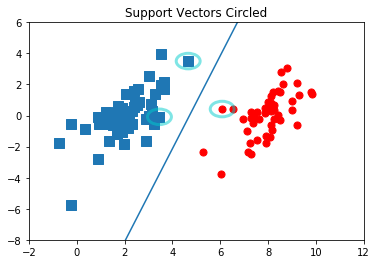

In [44]:
#线性分类绘图
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

xcord0 = []
ycord0 = []
xcord1 = []
ycord1 = []
markers =[]
colors =[]
with open('testSet.txt') as fr:
    frLines = fr.readlines()#this file was generated by 2normalGen.py

for line in frLines:
    lineSplit = line.strip().split('\t')
    xPt = float(lineSplit[0])
    yPt = float(lineSplit[1])
    label = int(lineSplit[2])
    if (label == -1):
        xcord0.append(xPt)
        ycord0.append(yPt)
    else:
        xcord1.append(xPt)
        ycord1.append(yPt)
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xcord0,ycord0, marker='s', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('Support Vectors Circled')
# b = -3.75567; w0=0.8065; w1=-0.2761
x = np.arange(-2.0, 12.0, 0.1)
y = (-w0*x - np.array(b))/w1
ax.plot(x,y.reshape(140))
ax.axis([-2,12,-8,6])

#给支持向量加标注
dataMat, labelMat = loadDataSet(fileName)
for i in range(len(dataMat)):
    if alpha[i] >0:
        print(dataMat[i], labelMat[i])
        circle = Circle((dataMat[i][0], dataMat[i][1]), 0.5, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
        ax.add_patch(circle)


plt.show()

In [45]:
y.reshape(140)

array([-20.09714036, -19.79774649, -19.49835262, -19.19895876,
       -18.89956489, -18.60017102, -18.30077715, -18.00138329,
       -17.70198942, -17.40259555, -17.10320169, -16.80380782,
       -16.50441395, -16.20502009, -15.90562622, -15.60623235,
       -15.30683849, -15.00744462, -14.70805075, -14.40865688,
       -14.10926302, -13.80986915, -13.51047528, -13.21108142,
       -12.91168755, -12.61229368, -12.31289982, -12.01350595,
       -11.71411208, -11.41471821, -11.11532435, -10.81593048,
       -10.51653661, -10.21714275,  -9.91774888,  -9.61835501,
        -9.31896115,  -9.01956728,  -8.72017341,  -8.42077955,
        -8.12138568,  -7.82199181,  -7.52259794,  -7.22320408,
        -6.92381021,  -6.62441634,  -6.32502248,  -6.02562861,
        -5.72623474,  -5.42684088,  -5.12744701,  -4.82805314,
        -4.52865928,  -4.22926541,  -3.92987154,  -3.63047767,
        -3.33108381,  -3.03168994,  -2.73229607,  -2.43290221,
        -2.13350834,  -1.83411447,  -1.53472061,  -1.23

## 完整的SMO算法加速优化（应用选择alpha的启发式方法：用于提速）

In [46]:
#建立赋值支持函数用于保存数据（虽然也可以用字典但是.X比【'X'】简便些）
#将样本特征保存在optStructK中
class optStruct:
    def __init__(self,dataMatIn, classLabels, C, toler):  
        #结构数据初始化
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = np.shape(dataMatIn)[0]
        self.alphas = np.mat(np.zeros((self.m,1)))
        self.b = 0
        self.eCache = np.mat(np.zeros((self.m,2))) #矩阵误差缓存，对每个样本设定两个空间的缓存保存
        
        
def calcEk(oS, k):
    #计算对应保存数据
    #对象所保存的预测函数参数值进行预测计算
    #对应对象oS 和对应样本k
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*(oS.X*oS.X[k,:].T)) + oS.b 
    Ek = fXk - float(oS.labelMat[k])#
    return Ek   #返回误差Ek

def selectJ(i, oS, Ei):         #this is the second choice -heurstic, and calcs Ej
    #启发式方法，保证在每次优化中具有最大步长,选择第二个变量alpha j
    #对确定外层循环i的内层循环

    maxK = -1#取得最大优化效果时第二个变量对应的序列k
    maxDeltaE = 0#E的差值E1-E2
    Ej = 0 #内层循环误差

    oS.eCache[i] = [1,Ei]  #对每个alpha i对应的Ei保存在结构化数据当中，不用重复计算，第一列置1，是为了确认误差是否存在
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]
    #取得相应误差缓存中对应已经存在误差的序列值的的一个
    #.A取矩阵（m,1）转化为数组(m,1)，array
    #取数组的
    #np.nonzero函数是numpy中用于得到数组array中非零元素的位置（数组索引）的函数
    #索引值数组的每一个array均是从一个维度上来描述其索引值。
    #比如，如果a是一个二维数组，则索引值数组有两个array，第一个array从行维度来描述索引值；第二个array从列维度来描述索引值。 

    if (len(validEcacheList)) > 1:
        #如果除了i自身，还存在其他误差
        for k in validEcacheList:   #遍历误差存咋alpha
            if k == i: 
                continue #等于i跳出循环

            Ek = calcEk(oS, k)#计算对象对应k的误差
            deltaE = abs(Ei - Ek)#E差值绝对值
            if (deltaE > maxDeltaE):
                #如果差值大于当前循环状态下最大deltaE
                maxK = k 
                maxDeltaE = deltaE 
                Ej = Ek
                #更新最大时对应最大值序列k和对应的delta，以及求得Ej
        return maxK, Ej#二轮对比最大deltaE循环结束后返回相对应的最大序列和Ej

    else:  #如果误差矩阵里不存在相应的误差，则直接采用随机选用第二个遍历
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej

#误差缓存矩阵更新
def updateEk(oS,k):
    #对os对象的第k个值进行更新
    Ek=calcEk(oS,k)
    oS.eCache[k]=[1,Ek]

**SMO优化过程**

In [47]:
#准备函数：内循环寻找alphaj，是否进行内层循环
def innerL(i, oS):
    Ei = calcEk(oS, i)#计算对应偏差
    
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        #如果偏差大于容忍度最终完成更新返回1，如果没有返回0表示未进行更新
        j,Ej = selectJ(i, oS, Ei) #内层循环的第二个alpha的选
        
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy();#保存alpha I和j的值
        
        #计算alpha范围L和H
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H:
            print("L==H")
            return 0  #函数直接返回0 ，不进行内层循环
        
        #eta计算与判定
        eta = 2.0 * oS.X[i,:]*oS.X[j,:].T - oS.X[i,:]*oS.X[i,:].T - oS.X[j,:]*oS.X[j,:].T
        if eta >= 0: 
            print("eta>=0"); 
            return 0#1
        
        #计算os对象
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta#未经裁剪的alpha
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)#由LH限制的alpha
        
        updateEk(oS, j) #在alpha 更新之后再更新对应y时保存的Ei
        
        #符合对更新的要求
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): 
            print("j 没有足够的优化")
            return 0
        
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])#update i by the same amount as j
        updateEk(oS, i) #added this for the Ecache                    #由j计算i之后在进行缓存中E的更新
        
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[i,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[j,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[j,:]*oS.X[j,:].T
         #计算对应i和j的b1和b2
        
        #保存并更新存放于对象中的b参数值
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): 
            oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): 
            oS.b = b2
        else: 
            oS.b = (b1 + b2)/2.0
        
        #返回1
        return 1
    else:
        return 0

In [48]:
#SMO外循环代码
def smoP(dataMatIn,classLabels,C,toler,maxIter):
    #输入矩阵，类别便签、阐述、容忍度、最大迭代次数、
    oS=optStruct(np.mat(dataMatIn),np.mat(classLabels).transpose(),C,toler)#将初始化的数据保存到对象当中

    #初始化相关参数
    iter=0 #当前迭代次数
    entireSet=True#是否在全部集合样本中继续参数优化
    alphaPairsChanged=0
    while iter<maxIter and (alphaPairsChanged>0) or (entireSet):
        #当未达到最大迭代次数且遍历整个数据集都未对alpha做修改
        alphaPairsChanged=0
        #没有alpha更新对
        if entireSet:
            #遍历数据集打印当前迭代次数下alpha改变了几次
            for i in range(oS.m):
                alphaPairsChanged+=innerL(i,oS) #该步骤如果进行内层循环的更新返回1，否则返回0，并且同时更新对象中的相关参数
                print("全部集合：第iter=%d次迭代，当前i=%d， alpha改变了%d次"%(iter, i, alphaPairsChanged))
        else:
            #统计alphas向量中满足0<alpha<C的alpha列表
            nonBoundIs=np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0] #返回符合条件的list序列
            for i in nonBoundIs:
                #遍历位于0——C之间的alpha
                alphaPairsChanged+=innerL(i,oS)#进行alpha的选择与更新
                print("")
                print("0-C范围之内：第iter=%d次迭代，当前i=%d， alpha改变了%d次"%(iter, i, alphaPairsChanged))
            iter+=1
        #在循环的最后进行判定
        if entireSet:
            #若本次将所有样本继续更新，亦以此就将器变为False不用对所有样本更新
            entireSet = False #toggle entire set loop
        elif (alphaPairsChanged == 0): 
            #若当前迭代更新中未发生alpha更新，因此需要扩大范围对所有i尝试更新
            entireSet = True  
        print("当前迭代次数：%d" % iter) 
    return oS.b,oS.alphas
        

In [49]:
dataMat, labelMat = loadDataSet(fileName)
dataMatIn, classLabels, C, toler, maxIter = dataMat, labelMat, 0.6, 0.001, 40
b , alpha = smoP(dataMat,classLabels,C,toler,maxIter)

全部集合：第iter=0次迭代，当前i=0， alpha改变了1次
全部集合：第iter=0次迭代，当前i=1， alpha改变了1次
全部集合：第iter=0次迭代，当前i=2， alpha改变了2次
全部集合：第iter=0次迭代，当前i=3， alpha改变了2次
全部集合：第iter=0次迭代，当前i=4， alpha改变了3次
全部集合：第iter=0次迭代，当前i=5， alpha改变了3次
全部集合：第iter=0次迭代，当前i=6， alpha改变了3次
全部集合：第iter=0次迭代，当前i=7， alpha改变了3次
j 没有足够的优化
全部集合：第iter=0次迭代，当前i=8， alpha改变了3次
全部集合：第iter=0次迭代，当前i=9， alpha改变了3次
j 没有足够的优化
全部集合：第iter=0次迭代，当前i=10， alpha改变了3次
全部集合：第iter=0次迭代，当前i=11， alpha改变了3次
全部集合：第iter=0次迭代，当前i=12， alpha改变了3次
全部集合：第iter=0次迭代，当前i=13， alpha改变了3次
全部集合：第iter=0次迭代，当前i=14， alpha改变了3次
全部集合：第iter=0次迭代，当前i=15， alpha改变了3次
全部集合：第iter=0次迭代，当前i=16， alpha改变了3次
j 没有足够的优化
全部集合：第iter=0次迭代，当前i=17， alpha改变了3次
全部集合：第iter=0次迭代，当前i=18， alpha改变了4次
全部集合：第iter=0次迭代，当前i=19， alpha改变了4次
全部集合：第iter=0次迭代，当前i=20， alpha改变了4次
全部集合：第iter=0次迭代，当前i=21， alpha改变了4次
全部集合：第iter=0次迭代，当前i=22， alpha改变了5次
全部集合：第iter=0次迭代，当前i=23， alpha改变了5次
全部集合：第iter=0次迭代，当前i=24， alpha改变了5次
L==H
全部集合：第iter=0次迭代，当前i=25， alpha改变了5次
L==H
全部集合：第iter=0次迭代，当前i=26， alpha改变了5次
全部集合：第iter=0次迭代，当前i=27， a

In [50]:
ws = calcWs(alpha,dataMat,labelMat )
w0 = ws[0][0]
w1 = ws[1][0]
w0,w1,b

(0.6908365750710709, -0.32762321892495877, matrix([[-3.06344545]]))

[3.542485, 1.977398] -1.0
[3.125951, 0.293251] -1.0
[4.658191, 3.507396] -1.0
[8.197181, 1.545132] 1.0
[5.286862, -2.358286] 1.0
[6.080573, 0.418886] 1.0


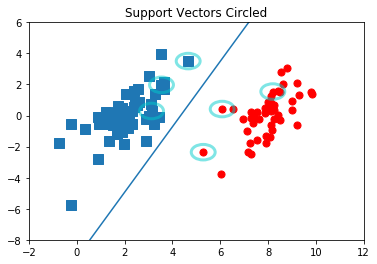

In [51]:
#线性分类绘图
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

xcord0 = []
ycord0 = []
xcord1 = []
ycord1 = []
markers =[]
colors =[]
with open('testSet.txt') as fr:
    frLines = fr.readlines()#this file was generated by 2normalGen.py

for line in frLines:
    lineSplit = line.strip().split('\t')
    xPt = float(lineSplit[0])
    yPt = float(lineSplit[1])
    label = int(lineSplit[2])
    if (label == -1):
        xcord0.append(xPt)
        ycord0.append(yPt)
    else:
        xcord1.append(xPt)
        ycord1.append(yPt)
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xcord0,ycord0, marker='s', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('Support Vectors Circled')
# b = -3.75567; w0=0.8065; w1=-0.2761
x = np.arange(-2.0, 12.0, 0.1)
y = (-w0*x - int(b))/w1
ax.plot(x,y)
ax.axis([-2,12,-8,6])

#给支持向量加标注
dataMat, labelMat = loadDataSet(fileName)
for i in range(len(dataMat)):
    if alpha[i] >0:
        print(dataMat[i], labelMat[i])
        circle = Circle((dataMat[i][0], dataMat[i][1]), 0.5, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
        # 0.5圈的大小 facecolor颜色  edgecolor颜色 linewidth=3线段, alpha=0.5颜色深浅
        ax.add_patch(circle)

plt.show()

## 应用核函数进行非线性分类

**核函数设定：径向基核函数（《机器学习实战》P106）等价于《统计学习方法》P122高斯核函数**

$$K(x, z) = exp(-\frac{||x-z||^2}{2\sigma^2})$$

In [117]:
def kernelTrans(X, A, kTup): #calc the kernel or transform data to a higher dimensional space
    # kTup是包含核函数信息的元组，
    #X是整个样本矩阵
    #A是对应特定序列的输入特征向量
    m,n = np.shape(X)
    K = np.mat(np.zeros((m,1)))
    #设定核函数初始化，对应经过核函数计算后的Kij
    
    if kTup[0]=='lin': 
        K = X * A.T   #线性核函数
        
    elif kTup[0]=='rbf':
        #高斯核函数
        for j in range(m):
            deltaRow = X[j,:] - A #对应每一行的x-z
            K[j] = deltaRow*deltaRow.T#求对应L2范数
        K = np.exp(K/(-1*kTup[1]**2)) #通过kTup导入告诉核函数的参数进行公式计算
    else: 
        raise NameError('不存在对应核函数')#自动引发异常，输出
    return K

In [108]:
#更该向量内积位核函数，更新对象中相关
class optStruct:
    def __init__(self,dataMatIn, classLabels, C, toler, kTup):  # Initialize the structure with the parameters 
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = np.shape(dataMatIn)[0]
        self.alphas = np.mat(np.zeros((self.m,1)))
        self.b = 0
        self.eCache = np.mat(np.zeros((self.m,2))) #first column is valid flag
        self.K = np.mat(np.zeros((self.m,self.m))) #初始化对象中的核函数矩阵值可以保存每一个i对应整体的核函数值
        for i in range(self.m):
            #循环对每个alpha i计算对应核函数的值
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)

In [119]:
def calcEk(oS, k):
    #Ek计算
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek
        
def selectJ(i, oS, Ei):         #this is the second choice -heurstic, and calcs Ej
    #内循环第二轮j选择
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    oS.eCache[i] = [1,Ei]  #set valid #choose the alpha that gives the maximum delta E
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:   #loop through valid Ecache values and find the one that maximizes delta E
            if k == i: 
                continue #don't calc for i, waste of time
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej
    else:   #in this case (first time around) we don't have any valid eCache values
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej

def updateEk(oS, k):#after any alpha has changed update the new value in the cache
    #对对象中对应k误差缓存进行更新
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1,Ek]

In [120]:
#更新二层循环中的相关K的计算
def innerL(i, oS):
    
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j,Ej = selectJ(i, oS, Ei) #this has been changed from selectJrand
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy();
        
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
            
        if L==H: 
            print("L==H"); 
            return 0
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j] #c更改为核函数后的eta差值计算
        if eta >= 0: 
            print("eta>=0"); 
            return 0
        
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        
        updateEk(oS, j) #added this for the Ecache
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): 
            print("j没有足够的更改"); 
            return 0
        
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])#update i by the same amount as j
        updateEk(oS, i) #added this for the Ecache                    #the update is in the oppostie direction
        
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]- oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
        #b1b2更新于核函数相关
        
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): 
            oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): 
            oS.b = b2
        else: 
            oS.b = (b1 + b2)/2.0
        return 1
    else: return 0

In [129]:
#外循环代码
def smoP(dataMatIn, classLabels, C, toler, maxIter,kTup=('lin', 0)):    #full Platt SMO
    oS = optStruct(np.mat(dataMatIn),np.mat(classLabels).transpose(),C,toler, kTup)
    iter = 0
    entireSet = True
    alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:   #go over all
            for i in range(oS.m):        
                alphaPairsChanged += innerL(i,oS)
                print("全部数据集iter: %d 当前循环到i=:%d, alpha的改变次数 %d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:#go over non-bound (railed) alphas
            nonBoundIs = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("支持向量范围内的更新iter: %d 当前循环到i:%d, alpha的改变次数 %d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet:
            entireSet = False #toggle entire set loop
        elif (alphaPairsChanged == 0):
            entireSet = True  
        print("当前迭代总数： %d" % iter)
    return oS.b,oS.alphas

In [122]:
#由alpha计算权重参数w
def calcWs(alphas,dataArr,classLabels):
    X = mat(dataArr); labelMat = mat(classLabels).transpose()
    m,n = shape(X)
    w = zeros((n,1))
    for i in range(m):
        w += multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w

** 数据分析过程：**

In [123]:
dataArr,labelArr = loadDataSet('testSetRBF.txt')

In [124]:
dataArr,labelArr

([[-0.214824, 0.662756],
  [-0.061569, -0.091875],
  [0.406933, 0.648055],
  [0.22365, 0.130142],
  [0.231317, 0.766906],
  [-0.7488, -0.531637],
  [-0.557789, 0.375797],
  [0.207123, -0.019463],
  [0.286462, 0.71947],
  [0.1953, -0.179039],
  [-0.152696, -0.15303],
  [0.384471, 0.653336],
  [-0.11728, -0.153217],
  [-0.238076, 0.000583],
  [-0.413576, 0.145681],
  [0.490767, -0.680029],
  [0.199894, -0.199381],
  [-0.356048, 0.53796],
  [-0.392868, -0.125261],
  [0.353588, -0.070617],
  [0.020984, 0.92572],
  [-0.475167, -0.346247],
  [0.074952, 0.042783],
  [0.394164, -0.058217],
  [0.663418, 0.436525],
  [0.402158, 0.577744],
  [-0.449349, -0.038074],
  [0.61908, -0.088188],
  [0.268066, -0.071621],
  [-0.015165, 0.359326],
  [0.539368, -0.374972],
  [-0.319153, 0.629673],
  [0.694424, 0.64118],
  [0.079522, 0.193198],
  [0.253289, -0.285861],
  [-0.035558, -0.010086],
  [-0.403483, 0.474466],
  [-0.034312, 0.995685],
  [-0.590657, 0.438051],
  [-0.098871, -0.023953],
  [-0.250001, 

[-1.5, 1.5, -1.5, 1.5]

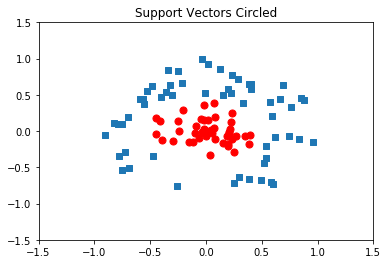

In [125]:
#绘制并观察数据分布
import numpy as np
import matplotlib.pyplot as plt

xcord0 = []
ycord0 = []
xcord1 = []
ycord1 = []
markers =[]
colors =[]
with open('testSetRBF.txt') as fr:
    frLines = fr.readlines()#this file was generated by 2normalGen.py

for line in frLines:
    lineSplit = line.strip().split('\t')
    xPt = float(lineSplit[0])
    yPt = float(lineSplit[1])
    label = int(float((lineSplit[2])))
    if (label == -1):
        xcord0.append(xPt)
        ycord0.append(yPt)
    else:
        xcord1.append(xPt)
        ycord1.append(yPt)
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xcord0,ycord0, marker='s', s=30)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('Support Vectors Circled')
ax.axis([-1.5,1.5,-1.5,1.5])

In [130]:
b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', k1)) #进行alpha更新

全部数据集iter: 0 当前循环到i=:0, alpha的改变次数 1
全部数据集iter: 0 当前循环到i=:1, alpha的改变次数 1
全部数据集iter: 0 当前循环到i=:2, alpha的改变次数 2
全部数据集iter: 0 当前循环到i=:3, alpha的改变次数 3
全部数据集iter: 0 当前循环到i=:4, alpha的改变次数 3
全部数据集iter: 0 当前循环到i=:5, alpha的改变次数 4
全部数据集iter: 0 当前循环到i=:6, alpha的改变次数 5
全部数据集iter: 0 当前循环到i=:7, alpha的改变次数 5
全部数据集iter: 0 当前循环到i=:8, alpha的改变次数 5
全部数据集iter: 0 当前循环到i=:9, alpha的改变次数 5
j没有足够的更改
全部数据集iter: 0 当前循环到i=:10, alpha的改变次数 5
全部数据集iter: 0 当前循环到i=:11, alpha的改变次数 6
全部数据集iter: 0 当前循环到i=:12, alpha的改变次数 6
全部数据集iter: 0 当前循环到i=:13, alpha的改变次数 6
全部数据集iter: 0 当前循环到i=:14, alpha的改变次数 7
全部数据集iter: 0 当前循环到i=:15, alpha的改变次数 8
全部数据集iter: 0 当前循环到i=:16, alpha的改变次数 9
全部数据集iter: 0 当前循环到i=:17, alpha的改变次数 9
全部数据集iter: 0 当前循环到i=:18, alpha的改变次数 10
全部数据集iter: 0 当前循环到i=:19, alpha的改变次数 10
全部数据集iter: 0 当前循环到i=:20, alpha的改变次数 10
全部数据集iter: 0 当前循环到i=:21, alpha的改变次数 11
全部数据集iter: 0 当前循环到i=:22, alpha的改变次数 12
j没有足够的更改
全部数据集iter: 0 当前循环到i=:23, alpha的改变次数 12
L==H
全部数据集iter: 0 当前循环到i=:24, alpha的改变次数 12
L==H
全部数据集iter: 0 当前循环到i=:25, 

In [132]:
#计算支持向量的数量
datMat=np.mat(dataArr)
labelMat = np.mat(labelArr).transpose()
svInd=np.nonzero(alphas.A>0)[0] #获取alpha中大于0的序列值
sVs=datMat[svInd] #取出对应的支持向量
labelSV = labelMat[svInd]; #取出对应标签
print("支持向量的数量%d " % np.shape(sVs)[0])

支持向量的数量16 


In [138]:
#计算训练集分类正确率
m,n = np.shape(datMat)
errorCount = 0
for i in range(m):
    kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1)) #k1是核函数的参数， 核函数转化
    predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b #预测值计算
    if np.sign(predict)!=np.sign(labelArr[i]): #sign分类取值函数
        errorCount += 1
print("the training error rate is: %f" % (float(errorCount)/m))

the training error rate is: 0.060000


In [143]:
#计算测试集分类正确率
dataArr,labelArr = loadDataSet('testSetRBF2.txt')
errorCount = 0
datMat=np.mat(dataArr)
labelMat = np.mat(labelArr).transpose()
m,n = np.shape(datMat)
for i in range(m):
    kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
    predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
    if np.sign(predict)!=np.sign(labelArr[i]):
        errorCount += 1    
print("the test error rate is: %f" % (float(errorCount)/m)) 

the test error rate is: 0.160000


## 样例手写数字分类

In [184]:
#辅助函数：对样本img到向量转化
def img2vector(filename):
    returnVect = np.zeros((1,1024))
    with open(filename) as fr:
        for i in range(32):
            lineStr = fr.readline()
            for j in range(32):
                returnVect[0,32*i+j] = int(lineStr[j])
    return returnVect

In [188]:
#根据文件名读取文件夹下文件转化为向量
def loadImages(dirName):
    from os import listdir
    hwLabels = []
    trainingFileList = listdir(dirName)           #load the training set
    m = len(trainingFileList)
    trainingMat = np.zeros((m,1024))
    for i in range(m):
        #读取文件名对应的标签数字，并且二分类是将9与其他类分隔开
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]     #take off .txt
        classNumStr = int(fileStr.split('_')[0])
        if classNumStr == 9: 
            hwLabels.append(-1)
        else: hwLabels.append(1)
        trainingMat[i,:] = img2vector('%s/%s' % (dirName, fileNameStr))
    return trainingMat, hwLabels 

In [196]:
#读取数据进行模型训练
kTup=('rbf', 10)
dataArr,labelArr = loadImages('trainingDigits')
b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, kTup)


全部数据集iter: 0 当前循环到i=:0, alpha的改变次数 1
全部数据集iter: 0 当前循环到i=:1, alpha的改变次数 2
全部数据集iter: 0 当前循环到i=:2, alpha的改变次数 3
全部数据集iter: 0 当前循环到i=:3, alpha的改变次数 4
全部数据集iter: 0 当前循环到i=:4, alpha的改变次数 5
全部数据集iter: 0 当前循环到i=:5, alpha的改变次数 6
全部数据集iter: 0 当前循环到i=:6, alpha的改变次数 7
全部数据集iter: 0 当前循环到i=:7, alpha的改变次数 8
全部数据集iter: 0 当前循环到i=:8, alpha的改变次数 9
全部数据集iter: 0 当前循环到i=:9, alpha的改变次数 10
全部数据集iter: 0 当前循环到i=:10, alpha的改变次数 11
全部数据集iter: 0 当前循环到i=:11, alpha的改变次数 12
全部数据集iter: 0 当前循环到i=:12, alpha的改变次数 13
全部数据集iter: 0 当前循环到i=:13, alpha的改变次数 14
全部数据集iter: 0 当前循环到i=:14, alpha的改变次数 15
全部数据集iter: 0 当前循环到i=:15, alpha的改变次数 16
全部数据集iter: 0 当前循环到i=:16, alpha的改变次数 16
全部数据集iter: 0 当前循环到i=:17, alpha的改变次数 17
全部数据集iter: 0 当前循环到i=:18, alpha的改变次数 18
全部数据集iter: 0 当前循环到i=:19, alpha的改变次数 19
全部数据集iter: 0 当前循环到i=:20, alpha的改变次数 20
全部数据集iter: 0 当前循环到i=:21, alpha的改变次数 21
全部数据集iter: 0 当前循环到i=:22, alpha的改变次数 22
j没有足够的更改
全部数据集iter: 0 当前循环到i=:23, alpha的改变次数 22
全部数据集iter: 0 当前循环到i=:24, alpha的改变次数 23
全部数据集iter: 0 当前循环到i=:25, alpha的改变次数

j没有足够的更改
全部数据集iter: 0 当前循环到i=:232, alpha的改变次数 62
全部数据集iter: 0 当前循环到i=:233, alpha的改变次数 63
全部数据集iter: 0 当前循环到i=:234, alpha的改变次数 64
全部数据集iter: 0 当前循环到i=:235, alpha的改变次数 65
全部数据集iter: 0 当前循环到i=:236, alpha的改变次数 66
全部数据集iter: 0 当前循环到i=:237, alpha的改变次数 66
全部数据集iter: 0 当前循环到i=:238, alpha的改变次数 67
全部数据集iter: 0 当前循环到i=:239, alpha的改变次数 67
全部数据集iter: 0 当前循环到i=:240, alpha的改变次数 67
全部数据集iter: 0 当前循环到i=:241, alpha的改变次数 67
全部数据集iter: 0 当前循环到i=:242, alpha的改变次数 68
全部数据集iter: 0 当前循环到i=:243, alpha的改变次数 69
j没有足够的更改
全部数据集iter: 0 当前循环到i=:244, alpha的改变次数 69
全部数据集iter: 0 当前循环到i=:245, alpha的改变次数 70
全部数据集iter: 0 当前循环到i=:246, alpha的改变次数 71
j没有足够的更改
全部数据集iter: 0 当前循环到i=:247, alpha的改变次数 71
全部数据集iter: 0 当前循环到i=:248, alpha的改变次数 72
全部数据集iter: 0 当前循环到i=:249, alpha的改变次数 73
全部数据集iter: 0 当前循环到i=:250, alpha的改变次数 73
全部数据集iter: 0 当前循环到i=:251, alpha的改变次数 73
全部数据集iter: 0 当前循环到i=:252, alpha的改变次数 74
全部数据集iter: 0 当前循环到i=:253, alpha的改变次数 75
全部数据集iter: 0 当前循环到i=:254, alpha的改变次数 76
全部数据集iter: 0 当前循环到i=:255, alpha的改变次数 76
全部数据集iter: 0 

j没有足够的更改
支持向量范围内的更新iter: 1 当前循环到i:72, alpha的改变次数 18
j没有足够的更改
支持向量范围内的更新iter: 1 当前循环到i:77, alpha的改变次数 18
支持向量范围内的更新iter: 1 当前循环到i:81, alpha的改变次数 19
j没有足够的更改
支持向量范围内的更新iter: 1 当前循环到i:82, alpha的改变次数 19
支持向量范围内的更新iter: 1 当前循环到i:83, alpha的改变次数 20
j没有足够的更改
支持向量范围内的更新iter: 1 当前循环到i:85, alpha的改变次数 20
支持向量范围内的更新iter: 1 当前循环到i:119, alpha的改变次数 21
支持向量范围内的更新iter: 1 当前循环到i:176, alpha的改变次数 22
j没有足够的更改
支持向量范围内的更新iter: 1 当前循环到i:177, alpha的改变次数 22
j没有足够的更改
支持向量范围内的更新iter: 1 当前循环到i:192, alpha的改变次数 22
j没有足够的更改
支持向量范围内的更新iter: 1 当前循环到i:195, alpha的改变次数 22
j没有足够的更改
支持向量范围内的更新iter: 1 当前循环到i:198, alpha的改变次数 22
j没有足够的更改
支持向量范围内的更新iter: 1 当前循环到i:199, alpha的改变次数 22
j没有足够的更改
支持向量范围内的更新iter: 1 当前循环到i:200, alpha的改变次数 22
j没有足够的更改
支持向量范围内的更新iter: 1 当前循环到i:201, alpha的改变次数 22
j没有足够的更改
支持向量范围内的更新iter: 1 当前循环到i:204, alpha的改变次数 22
j没有足够的更改
支持向量范围内的更新iter: 1 当前循环到i:205, alpha的改变次数 22
j没有足够的更改
支持向量范围内的更新iter: 1 当前循环到i:207, alpha的改变次数 22
j没有足够的更改
支持向量范围内的更新iter: 1 当前循环到i:208, alpha的改变次数 22
j没有足够的更改
支持向量范围内的更新iter: 1 当前循环到i:2

j没有足够的更改
全部数据集iter: 3 当前循环到i=:7, alpha的改变次数 0
全部数据集iter: 3 当前循环到i=:8, alpha的改变次数 0
全部数据集iter: 3 当前循环到i=:9, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 3 当前循环到i=:10, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 3 当前循环到i=:11, alpha的改变次数 0
L==H
全部数据集iter: 3 当前循环到i=:12, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 3 当前循环到i=:13, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 3 当前循环到i=:14, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 3 当前循环到i=:15, alpha的改变次数 0
L==H
全部数据集iter: 3 当前循环到i=:16, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 3 当前循环到i=:17, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 3 当前循环到i=:18, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 3 当前循环到i=:19, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 3 当前循环到i=:20, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 3 当前循环到i=:21, alpha的改变次数 0
全部数据集iter: 3 当前循环到i=:22, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 3 当前循环到i=:23, alpha的改变次数 0
全部数据集iter: 3 当前循环到i=:24, alpha的改变次数 0
全部数据集iter: 3 当前循环到i=:25, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 3 当前循环到i=:26, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 3 当前循环到i=:27, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 3 当前循环到i=:28, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 3 

全部数据集iter: 3 当前循环到i=:207, alpha的改变次数 12
全部数据集iter: 3 当前循环到i=:208, alpha的改变次数 13
全部数据集iter: 3 当前循环到i=:209, alpha的改变次数 14
全部数据集iter: 3 当前循环到i=:210, alpha的改变次数 15
全部数据集iter: 3 当前循环到i=:211, alpha的改变次数 16
全部数据集iter: 3 当前循环到i=:212, alpha的改变次数 17
全部数据集iter: 3 当前循环到i=:213, alpha的改变次数 17
全部数据集iter: 3 当前循环到i=:214, alpha的改变次数 17
全部数据集iter: 3 当前循环到i=:215, alpha的改变次数 18
全部数据集iter: 3 当前循环到i=:216, alpha的改变次数 19
全部数据集iter: 3 当前循环到i=:217, alpha的改变次数 19
全部数据集iter: 3 当前循环到i=:218, alpha的改变次数 20
全部数据集iter: 3 当前循环到i=:219, alpha的改变次数 20
全部数据集iter: 3 当前循环到i=:220, alpha的改变次数 20
全部数据集iter: 3 当前循环到i=:221, alpha的改变次数 21
全部数据集iter: 3 当前循环到i=:222, alpha的改变次数 21
全部数据集iter: 3 当前循环到i=:223, alpha的改变次数 21
全部数据集iter: 3 当前循环到i=:224, alpha的改变次数 21
全部数据集iter: 3 当前循环到i=:225, alpha的改变次数 21
全部数据集iter: 3 当前循环到i=:226, alpha的改变次数 22
全部数据集iter: 3 当前循环到i=:227, alpha的改变次数 22
全部数据集iter: 3 当前循环到i=:228, alpha的改变次数 22
全部数据集iter: 3 当前循环到i=:229, alpha的改变次数 22
全部数据集iter: 3 当前循环到i=:230, alpha的改变次数 22
全部数据集iter: 3 当前循环到i=:231, alpha的改变次数 22


j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:2, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:3, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:4, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:5, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:6, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:7, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:8, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:10, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:11, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:13, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:14, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:15, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:18, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:20, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:21, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:22, alpha的改变次数 0
支持向量范围内的更新iter: 4 当前循环到i:23, alpha的改变次数 1
支持向量范围内的更新iter: 4 当前循环到i:47, alpha的改变次数 2
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:49, alpha的改变次数 2
j没有足够的更改
支持向量范围内的更新iter: 4 当前循环到i:51, alpha的改变次数 2
j没有足够

j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:232, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:233, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:235, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:236, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:238, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:242, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:245, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:249, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:250, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:252, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:253, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:254, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:258, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:259, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:260, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:277, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:282, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:284, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 5 当前循环到i:286, alpha的改变次数 0
j没有足够的更改
支持向

L==H
全部数据集iter: 6 当前循环到i=:188, alpha的改变次数 0
L==H
全部数据集iter: 6 当前循环到i=:189, alpha的改变次数 0
全部数据集iter: 6 当前循环到i=:190, alpha的改变次数 0
全部数据集iter: 6 当前循环到i=:191, alpha的改变次数 0
全部数据集iter: 6 当前循环到i=:192, alpha的改变次数 0
全部数据集iter: 6 当前循环到i=:193, alpha的改变次数 0
全部数据集iter: 6 当前循环到i=:194, alpha的改变次数 0
全部数据集iter: 6 当前循环到i=:195, alpha的改变次数 0
全部数据集iter: 6 当前循环到i=:196, alpha的改变次数 0
全部数据集iter: 6 当前循环到i=:197, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 6 当前循环到i=:198, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 6 当前循环到i=:199, alpha的改变次数 0
全部数据集iter: 6 当前循环到i=:200, alpha的改变次数 1
j没有足够的更改
全部数据集iter: 6 当前循环到i=:201, alpha的改变次数 1
全部数据集iter: 6 当前循环到i=:202, alpha的改变次数 1
j没有足够的更改
全部数据集iter: 6 当前循环到i=:203, alpha的改变次数 1
j没有足够的更改
全部数据集iter: 6 当前循环到i=:204, alpha的改变次数 1
j没有足够的更改
全部数据集iter: 6 当前循环到i=:205, alpha的改变次数 1
j没有足够的更改
全部数据集iter: 6 当前循环到i=:206, alpha的改变次数 1
j没有足够的更改
全部数据集iter: 6 当前循环到i=:207, alpha的改变次数 1
j没有足够的更改
全部数据集iter: 6 当前循环到i=:208, alpha的改变次数 1
j没有足够的更改
全部数据集iter: 6 当前循环到i=:209, alpha的改变次数 1
j没有足够的更改
全部数据集iter: 6 当前循环到i=:210, alpha的改

L==H
全部数据集iter: 6 当前循环到i=:389, alpha的改变次数 12
全部数据集iter: 6 当前循环到i=:390, alpha的改变次数 12
全部数据集iter: 6 当前循环到i=:391, alpha的改变次数 12
j没有足够的更改
全部数据集iter: 6 当前循环到i=:392, alpha的改变次数 12
全部数据集iter: 6 当前循环到i=:393, alpha的改变次数 12
全部数据集iter: 6 当前循环到i=:394, alpha的改变次数 12
全部数据集iter: 6 当前循环到i=:395, alpha的改变次数 12
全部数据集iter: 6 当前循环到i=:396, alpha的改变次数 12
全部数据集iter: 6 当前循环到i=:397, alpha的改变次数 12
j没有足够的更改
全部数据集iter: 6 当前循环到i=:398, alpha的改变次数 12
L==H
全部数据集iter: 6 当前循环到i=:399, alpha的改变次数 12
全部数据集iter: 6 当前循环到i=:400, alpha的改变次数 12
j没有足够的更改
全部数据集iter: 6 当前循环到i=:401, alpha的改变次数 12
当前迭代总数： 7
j没有足够的更改
支持向量范围内的更新iter: 7 当前循环到i:0, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 7 当前循环到i:1, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 7 当前循环到i:3, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 7 当前循环到i:4, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 7 当前循环到i:5, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 7 当前循环到i:6, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 7 当前循环到i:7, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 7 当前循环到i:8, alpha的改变次数 0
j没有足够的更改
支持向量范围内的更新iter: 7 当前循环到i

j没有足够的更改
全部数据集iter: 8 当前循环到i=:82, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 8 当前循环到i=:83, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:84, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 8 当前循环到i=:85, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:86, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 8 当前循环到i=:87, alpha的改变次数 0
L==H
全部数据集iter: 8 当前循环到i=:88, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:89, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:90, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 8 当前循环到i=:91, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:92, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 8 当前循环到i=:93, alpha的改变次数 0
L==H
全部数据集iter: 8 当前循环到i=:94, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 8 当前循环到i=:95, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 8 当前循环到i=:96, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:97, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 8 当前循环到i=:98, alpha的改变次数 0
L==H
全部数据集iter: 8 当前循环到i=:99, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:100, alpha的改变次数 0
L==H
全部数据集iter: 8 当前循环到i=:101, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:102, alpha的改变次数 0
L==H
全部数据集iter: 8 当前循环到i=:103, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 8 当前循环到i=:104, alpha的改变次数 0
j没有足够的

全部数据集iter: 8 当前循环到i=:296, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:297, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 8 当前循环到i=:298, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:299, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:300, alpha的改变次数 0
L==H
全部数据集iter: 8 当前循环到i=:301, alpha的改变次数 0
L==H
全部数据集iter: 8 当前循环到i=:302, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:303, alpha的改变次数 0
L==H
全部数据集iter: 8 当前循环到i=:304, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 8 当前循环到i=:305, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 8 当前循环到i=:306, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:307, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:308, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:309, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:310, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 8 当前循环到i=:311, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:312, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:313, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:314, alpha的改变次数 0
L==H
全部数据集iter: 8 当前循环到i=:315, alpha的改变次数 0
全部数据集iter: 8 当前循环到i=:316, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 8 当前循环到i=:317, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 8 当前循环到i=:318, alpha的改变次数 0
j没有足够的更改
全部数据集iter: 8 当前循环到i=

In [204]:
#打印支持向量的数量，并保存
datMat=np.mat(dataArr)
labelMat = np.mat(labelArr).transpose()
svInd=np.nonzero(alphas.A>0)[0]
sVs=datMat[svInd] 
labelSV = labelMat[svInd]
print("there are %d Support Vectors" % np.shape(sVs)[0])

there are 122 Support Vectors


In [201]:
datMat.shape

(186, 1024)

In [207]:
#训练集正确率
m,n = np.shape(datMat)
errorCount = 0
for i in range(m):
    kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
    predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
    if np.sign(predict)!=np.sign(labelArr[i]): errorCount += 1
print("the training error rate is: %f" % (float(errorCount)/m))

the training error rate is: 0.000000


In [209]:
dataArr,labelArr = loadImages('testDigits')
errorCount = 0
datMat=np.mat(dataArr)
labelMat = np.mat(labelArr).transpose()
m,n = np.shape(datMat)
for i in range(m):
    kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
    predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
    if np.sign(predict)!=np.sign(labelArr[i]): 
        errorCount += 1    
print("the test error rate is: %f" % (float(errorCount)/m)) 

the test error rate is: 0.005376
